In [86]:
# Imports
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import uuid
import mlflow
import mlflow.sklearn

from datetime import datetime

from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MultiLabelBinarizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, root_mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [87]:
# Directory config to project root to insure consistency across environments for project specific imports
from pyprojroot import here
os.chdir(here())

# Project specific imports
from src.utils import save_dataframe

## Data Loading

I have set up multiple versions of my dataset, and the section below is used to swap between them for experimentation.

The main purpose behind this setup is to run experiments on data that has been imputed with and without the target included in the inputs for the imputation. I also investigate the effect of splitting the data into train and test sets before imputing.

In [88]:
target = 'revenue'

### Imputed Data with Target Included

This version of the dataset uses all available features during imputation, including the target variable. It is primarily intended for exploratory analysis to understand the impact of including the target variable in the imputation process.

In [89]:
# # Load dataset
# data = pd.read_csv("./data/1.1_imputed_data_full.csv")

# # Data filters
# data = data.dropna(subset=['revenue'])
# # data = data[data["budget_missing"] == 0]
# # data = data[data["revenue_missing"] == 0]
# # data = data[data["budget_missing"] == 0 & data["revenue_missing"] == 0]
# # data = data[(data["budget_missing"] == 0) & (data["revenue_missing"] == 0)]

# # Split X/y
# # X = data.drop(columns=[target])
# X = data.drop(columns=[target, 'revenue_missing'])
# y = data[target]

# # Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train.info()

### Imputed Data with Target Excluded

The target variable was excluded from the imputation process to prevent data leakage and ensure a more reliable model evaluation.  

Since missing values in the target column were not imputed, they will have to be dropped, reducing the available data for training. This approach prioritizes model integrity over dataset size, avoiding potential bias introduced by artificially inferred target values.


In [90]:
# # Load dataset
# data = pd.read_csv("./data/1.2_imputed_data_no_revenue.csv")

# # Data filters
# data = data.dropna(subset=['revenue'])
# # data = data[data["budget_missing"] == 0]
# # data = data[data["revenue_missing"] == 0]
# # data = data[data["budget_missing"] == 0 & data["revenue_missing"] == 0]
# # data = data[(data["budget_missing"] == 0) & (data["revenue_missing"] == 0)]

# # Split X/y
# X = data.drop(columns=[target])
# y = data[target]

# # Train/Test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train.info()

### Imputed Data with Pre-Split Train/Test Sets

The dataset was first divided into training and testing subsets before performing imputation. 

This approach ensures that the imputation model is fitted solely on the training data, thereby preventing data leakage and preserving the integrity of model evaluation. Splitting the data before imputation also helps simulate a real-world scenario, ensuring that the imputed values are more robust and generalizable when applied to unseen data.


In [91]:
X_train = pd.read_csv("./data/1.3.1_X_train_imputed.csv")
X_test = pd.read_csv("./data/1.3.2_X_test_imputed.csv")
y_train = pd.read_csv("./data/1.3.3_y_train.csv")
y_test = pd.read_csv("./data/1.3.4_y_test.csv")

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6275 entries, 0 to 6274
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   metascore                       6275 non-null   float64
 1   rotten_tomatoes_rating          6275 non-null   float64
 2   meta_critic_rating              6275 non-null   float64
 3   budget                          6275 non-null   float64
 4   metascore_missing               6275 non-null   int64  
 5   rotten_tomatoes_rating_missing  6275 non-null   int64  
 6   meta_critic_rating_missing      6275 non-null   int64  
 7   budget_missing                  6275 non-null   int64  
 8   total_wins                      6275 non-null   int64  
 9   total_noms                      6275 non-null   int64  
 10  oscar_wins                      6275 non-null   int64  
 11  oscar_noms                      6275 non-null   int64  
 12  bafta_wins                      62

## MultiLabel Binarizer

Custom transformer to handle multi-label categorical features by encoding them into separate binary columns.  

This transformer:
- Splits values in the specified column using a delimiter (default: ",").
- Replaces spaces with underscores to ensure consistent naming.
- Applies `MultiLabelBinarizer` to encode the unique values as binary features.
- Preserves feature names with an optional prefix for clarity.
  
Designed for use within a `ColumnTransformer`, allowing seamless transformation of multiple multi-label features as part of a `Pipeline`.


In [92]:
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer that applies MultiLabelBinarizer to a specified column.
    It splits the column values using a delimiter, replaces spaces with underscores,
    fits a MultiLabelBinarizer during fit, and transforms new data using the learned classes.
    
    Parameters
    ----------
    column : str
        The name of the column to encode.
    delimiter : str, default=","
        The delimiter used in the column to separate values.
    prefix : str, optional
        The prefix for the dummy columns. If None, uses the column name.
    """
    def __init__(self, column, delimiter=",", prefix=None):
        self.column = column
        self.delimiter = delimiter
        self.prefix = prefix if prefix is not None else column
        self.mlb_ = None
        
    def fit(self, X, y=None):
        X = X.copy()
        # Convert the column values into lists
        list_col = X[self.column].apply(
            lambda x: [i.strip().replace(' ', '_') for i in x.split(self.delimiter)] if pd.notnull(x) else []
        )
        self.mlb_ = MultiLabelBinarizer()
        self.mlb_.fit(list_col)
        return self
    
    def transform(self, X):
        X = X.copy()
        # Convert column values into lists as in fit
        list_col = X[self.column].apply(
            lambda x: [i.strip().replace(' ', '_') for i in x.split(self.delimiter)] if pd.notnull(x) else []
        )
        dummies = pd.DataFrame(
            self.mlb_.transform(list_col),
            columns=[f"{self.prefix}_{cls}" for cls in self.mlb_.classes_],
            index=X.index
        )
        # Drop the original column and add the dummies.
        X = X.drop(columns=[self.column])
        X = pd.concat([X, dummies], axis=1)
        return X
    
    def get_feature_names_out(self, input_features=None):
        return [f"{self.prefix}_{cls}" for cls in self.mlb_.classes_]

# To apply this transformer for multiple columns in a ColumnTransformer:
from sklearn.compose import ColumnTransformer

mlb_features = ['genre_names', 'production_country_name', 'spoken_languages']

transformers = [
    (f"mlb_{feat}", MultiLabelBinarizerTransformer(column=feat, delimiter=","), [feat])
    for feat in mlb_features
]

mlb = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Set output to pandas dataframe
mlb.set_output(transform='pandas')

# Apply transformation
# transformed_data = ct.fit_transform(data)
# if not isinstance(transformed_data, pd.DataFrame):
#     transformed_data = pd.DataFrame(transformed_data)
    
# print(transformed_data.head())

ColumnTransformer(remainder='passthrough',
                  transformers=[('mlb_genre_names',
                                 MultiLabelBinarizerTransformer(column='genre_names',
                                                                prefix='genre_names'),
                                 ['genre_names']),
                                ('mlb_production_country_name',
                                 MultiLabelBinarizerTransformer(column='production_country_name',
                                                                prefix='production_country_name'),
                                 ['production_country_name']),
                                ('mlb_spoken_languages',
                                 MultiLabelBinarizerTransformer(column='spoken_languages',
                                                                prefix='spoken_languages'),
                                 ['spoken_languages'])],
                  verbose_feature_names_out=False)

In [93]:
# Set up list of numerical coluns
num_cols = make_column_selector(dtype_include=['number'])
num_cols = num_cols(X_train)

# Display list
# for col in num_cols:
#     print(col)

print(num_cols)

['metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'metascore_missing', 'rotten_tomatoes_rating_missing', 'meta_critic_rating_missing', 'budget_missing', 'total_wins', 'total_noms', 'oscar_wins', 'oscar_noms', 'bafta_wins', 'bafta_noms', 'release_year', 'release_month', 'release_day', 'is_weekend', 'is_holiday_season', 'movie_age', 'imdb_rating', 'imdb_votes', 'tmdb_vote_count', 'tmdb_vote_average', 'runtime_in_min', 'tmdb_popularity']


In [94]:
# Set up list of categorical coluns
cat_cols = make_column_selector(dtype_include=['object'])
cat_cols = cat_cols(X_train)

# Display list
# for col in cat_cols:
#     print(col)

print(cat_cols)

['release_date', 'production_country_name', 'spoken_languages', 'first_billing_actor', 'second_billing_actor', 'third_billing_actor', 'main_director', 'main_writer', 'secondary_writer', 'title', 'genre_names', 'production_company_name', 'age_rating']


## Scalers and Encoders  

ColumnTransformer pipeline to preprocess numerical and categorical features for modeling.  

This transformation includes:  
- **StandardScaler**: Normalizes numerical features to ensure consistent scale.  
- **OneHotEncoder**: Encodes categorical variables as binary columns while ignoring unknown categories.  
- **OrdinalEncoder**: Assigns ordered integer values to categorical features, with unknown values handled explicitly.  

The transformer is configured to output a pandas DataFrame for seamless integration into the modeling pipeline.  


In [95]:
modeling_transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), [
            'metascore', 'rotten_tomatoes_rating', 'meta_critic_rating', 'budget', 'tmdb_vote_count', 'tmdb_vote_average', 'runtime_in_min', 
            'tmdb_popularity', 'imdb_rating', 'imdb_votes', 'total_wins', 'total_noms', 'oscar_wins', 'oscar_noms', 'bafta_wins', 'bafta_noms', 
            'release_year', 'release_month', 'release_day', 'movie_age', 
            # 'roi', 'revenue'
            ]),
        ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['age_rating']),
        ('OrdinalEncoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999999), ['first_billing_actor', 'second_billing_actor', 'third_billing_actor', 'main_director', 'main_writer', 'secondary_writer'])
    ],
    remainder='passthrough', 
    verbose_feature_names_out=False,
)

# Set output to pandas dataframe
modeling_transformer.set_output(transform='pandas')

# transformed_data = modeling_transformer.fit_transform(data)
# transformed_data.head()

ColumnTransformer(remainder='passthrough',
                  transformers=[('scaler', StandardScaler(),
                                 ['metascore', 'rotten_tomatoes_rating',
                                  'meta_critic_rating', 'budget',
                                  'tmdb_vote_count', 'tmdb_vote_average',
                                  'runtime_in_min', 'tmdb_popularity',
                                  'imdb_rating', 'imdb_votes', 'total_wins',
                                  'total_noms', 'oscar_wins', 'oscar_noms',
                                  'bafta_wins', 'bafta_noms', 'release_year',
                                  'relea...',
                                  'movie_age']),
                                ('OneHotEncoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['age_rating']),
                                ('OrdinalEncoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=999999),
                                 ['first_billing_actor', 'second_billing_actor',
                                  'third_billing_actor', 'main_director',
                                  'main_writer', 'secondary_writer'])],
                  verbose_feature_names_out=False)

In [96]:
# Define a function transformer to drop unwanted columns.
def drop_unwanted_columns(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    return df.drop(columns=columns, errors='ignore')

# List of unwanted columns
columns_to_drop = ['production_company_name', 'director', 'writer', 'actors', 'title', 'release_date']

# initialize dropper
dropper = FunctionTransformer(drop_unwanted_columns, kw_args={'columns': columns_to_drop})

## Applying transformation

### Setting up the pipeline

This pipeline includes:  
- **modeling_transformer**: Applies scaling and encoding transformations.  
- **mlb**: Binarizes multi-label categorical features.  
- **dropper**: Removes unnecessary columns for cleaner data.  

The transformed dataset is ready for model training and evaluation.  

In [97]:
# Build pipeline
scaling_pipeline = Pipeline(steps=[
    ('modeling_transformer', modeling_transformer),
    # ('mlb', mlb_transformer),
    ('mlb', mlb),
    ('dropper', dropper)
])

# scaled_data = scaling_pipeline.fit_transform(data)
# scaled_data.info()

In [98]:
# Fit the pipeline on the training data
X_train_scaled = scaling_pipeline.fit_transform(X_train, y_train)

# Transform the test data using the same pipeline
X_test_scaled = scaling_pipeline.transform(X_test)

In [99]:
X_train_scaled.head()

,genre_names_Action,genre_names_Adventure,genre_names_Animation,genre_names_Comedy,genre_names_Crime,genre_names_Documentary,genre_names_Drama,genre_names_Family,genre_names_Fantasy,genre_names_History,...,third_billing_actor,main_director,main_writer,secondary_writer,metascore_missing,rotten_tomatoes_rating_missing,meta_critic_rating_missing,budget_missing,is_weekend,is_holiday_season
0,0,0,0,0,0,0,1,0,0,0,...,2358.0,1010.0,1853.0,2265.0,0,0,0,1,1,0
1,0,0,0,0,1,0,1,0,0,0,...,3826.0,2399.0,1907.0,571.0,0,0,0,0,0,0
2,0,0,0,1,1,0,1,0,0,0,...,3254.0,488.0,708.0,2265.0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1621.0,2371.0,3371.0,195.0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,3169.0,2656.0,2150.0,2265.0,0,1,0,0,1,0


## Model Training and Optimization

### Evaluation Function

The `model_evaluation` function assesses multiple regression models using 5-fold cross-validation.  
It computes and reports the mean R² and RMSE scores for each model, providing a comparative analysis of their performance.  

- **R² Score**: Measures how well the model explains variance in the target variable.  
- **RMSE Score**: Indicates the model's prediction error in the original units of the target variable.  

The results are stored in a dictionary and printed in a structured format for easy interpretation.  


In [100]:
def model_evaluation(models: dict, X_train, y_train, w_train=None):
    """
    Evaluates regression models using Cross Validation.
    Returns a report with R² and RMSE scores.
    """
    
    evaluation_report = {}

    for model_name, model in models.items():
        # R² Score
        r2_scores = cross_val_score(
            model, 
            X_train, 
            y_train, 
            cv=5, 
            scoring="r2", 
            n_jobs=-1
        )
        
        # RMSE Score
        rmse_scores = cross_val_score(
            model, X_train, y_train, 
            cv=5, 
            scoring=make_scorer(lambda y, y_pred: root_mean_squared_error(y, y_pred)), 
            n_jobs=-1
        )

        # Store results
        evaluation_report[model_name] = {
            "R² Mean": np.mean(r2_scores),
            "RMSE Mean": np.mean(rmse_scores)
        }
        
        # Print results
        print(f"{model_name}:")
        print(f"- CV R² scores: {' | '.join([f'{r * 100:.1f}%' for r in r2_scores])}")
        print(f"- Mean R²: {np.mean(r2_scores) * 100:.1f}%")
        print("- -----------------------------------------------------------------------------------------------------------")
        print(f"- CV RMSE scores: {' | '.join([f'{r:,.0f}$' for r in rmse_scores])}")
        print(f"- Mean RMSE: {np.mean(rmse_scores):,.0f}$")
        print()


    
    return evaluation_report

models = {
    # "Linear Regression": LinearRegression(),
    # "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost Regressor": XGBRegressor(random_state=42),
    "LightGBM Regressor": LGBMRegressor(random_state=42),
    # "KNeighbors Regressor": KNeighborsRegressor(),
    # "SVR": SVR()
}


In [101]:
# Run initial evaluation
_ = model_evaluation(models, X_train_scaled, y_train)

Random Forest Regressor:
- CV R² scores: 77.5% | 75.3% | 74.1% | 75.2% | 81.2%
- Mean R²: 76.6%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 89,914,813$ | 88,392,875$ | 99,238,880$ | 83,075,866$ | 71,463,750$
- Mean RMSE: 86,417,237$

Gradient Boosting Regressor:
- CV R² scores: 80.4% | 74.8% | 75.5% | 75.6% | 79.5%
- Mean R²: 77.2%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 83,898,840$ | 89,313,678$ | 96,389,875$ | 82,365,111$ | 74,600,224$
- Mean RMSE: 85,313,546$

XGBoost Regressor:
- CV R² scores: 81.3% | 77.1% | 69.3% | 77.1% | 79.4%
- Mean R²: 76.9%
- -----------------------------------------------------------------------------------------------------------
- CV RMSE scores: 81,949,846$ | 85,130,247$ | 107,956,630$ | 79,728,843$ | 74,729,265$
- Mean RMSE: 85,898,966$

LightGBM Regressor:
- CV R² scores: 81.0% | 76.

### Parameter Tuning Function

The `tune_params_regression` function optimizes hyperparameters for a regression model using `GridSearchCV`.  
It performs 5-fold cross-validation to identify the best parameter set based on a specified scoring metric.

- **MLflow Integration**: Logs model parameters, performance metrics (R², RMSE), and training data artifacts.  
- **Experiment Tracking**: Assigns unique experiment and run names for reproducibility.  
- **Artifact Storage**: Saves datasets and trained models for further analysis.  
- **Performance Reporting**: Displays the best hyperparameters and test set evaluation results.  


In [102]:
def tune_params_regression(model, X_train, X_test, y_train, y_test, param_grid, scoring='r2'):
    """
    Evaluates a regression model using cross-validation and logs parameters and metrics with MLflow.
    Returns the best estimator.
    
    Parameters
    ----------
    model : estimator
        The regression model instance.
    X_train, X_test : DataFrame or array-like
        Training and testing features.
    y_train, y_test : array-like
        Training and testing target values.
    param_grid : dict
        The grid of parameters for GridSearchCV.
    scoring : str, default='r2'
        The scoring metric for GridSearchCV.
        
    Returns
    -------
    best_model : estimator
        The best estimator found by GridSearchCV.
    """
    # Define an experiment name using model type and timestamp.
    experiment_name = f"Exp_{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    mlflow.set_experiment(experiment_name)

    # Define a custom run name and run_id.
    run_name = f"{model.__class__.__name__}_Run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    run_id = f"{model.__class__.__name__}_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}_{str(uuid.uuid4())[:8]}"

    with mlflow.start_run(run_name=run_name):

        # MlFlow logs
        mlflow.log_param("model_type", model.__class__.__name__)

        # Ensure artifact folder exists.
        os.makedirs("./data/artifacts", exist_ok=True)

        # Save the training data CSVs in the artifacts folder.
        X_train.to_csv("./data/artifacts/X_train.csv", index=False)
        y_train.to_csv("./data/artifacts/y_train.csv", index=False)

        # Log these files as artifacts.
        mlflow.log_artifact("./data/artifacts/X_train.csv", artifact_path="datasets")
        mlflow.log_artifact("./data/artifacts/y_train.csv", artifact_path="datasets")
        
        # Initialize GridSearchCV for regression.
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            scoring=scoring,
            cv=5,
            n_jobs=-1
        )
        
        # Fit the model on the training data.
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Predict on the test set.
        y_pred = best_model.predict(X_test)
        
        # Compute R² and RMSE.
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        
        # Log metrics to MLflow.
        mlflow.log_metric("r2_score", r2)
        mlflow.log_metric("rmse", rmse)
        mlflow.log_params(grid_search.best_params_)
        mlflow.sklearn.log_model(best_model, f"Tuned_{model.__class__.__name__}", input_example=X_train.iloc[:20])
        
        # Print out the results.
        r2_formatted = f"{r2 * 100:.1f}%"
        rmse_formatted = f"{rmse:,.0f}$"
        print("----------------------------------------")
        print(f"Test Data Results")
        print(f"- R² Score: {r2_formatted}")
        print(f"- RMSE: {rmse_formatted}")
        print("----------------------------------------")
        print("Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"- {param}: {value}")
        print("----------------------------------------")
        
        return best_model


### Evaluating Model Performance

#### Evaluation Function

This function, `evaluate_model`, takes a trained regression model along with its test dataset (features and target values) and computes essential performance metrics. It calculates the R² score (converted to a percentage) and the Root Mean Squared Error (RMSE), then prints these results along with the model's name. Additionally, it visualizes the distribution of residuals via a histogram to help assess model errors. Finally, it returns a dictionary containing the R² and RMSE scores for further analysis.


In [117]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluates a trained regression model on test data.
    
    Parameters
    ----------
    model_name : str
        The name of the model for display.
    model : estimator
        The trained regression model.
    X_test : DataFrame or array-like
        Test features.
    y_test : array-like
        True target values.
    
    Returns
    -------
    dict
        A dictionary containing R² and RMSE scores.
    """
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Compute evaluation metrics
    r2 = r2_score(y_test, y_pred) * 100  # Convert to percentage
    rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error

    # Get model name
    model_name = model.__class__.__name__
    
    # Print results
    print(f"{model_name}:")
    print(f"  - R² Score: {r2:.1f}%")
    print(f"  - RMSE: {rmse:,.0f}$\n")

    # Convert to 1D if necessary
    y_test = y_test.values.flatten()

    # Plot Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    sns.histplot(residuals, kde=True, bins=30)
    plt.xlabel("Residuals")
    plt.ylabel("Density")
    plt.title(f"Residual Distribution for {model_name}")
    plt.show()
    
    return {"R²": r2, "RMSE": rmse}

#### Feature Importances function

This function calculates and displays the feature importances of a trained model. It extracts the feature importance values from the model, sorts them in descending order, and plots the top 20 most important features.

In [119]:
def display_feature_importances(model, dataframe):
    """
    Displays and plots the importance of features for a trained model.
    
    This function extracts the feature importances from the trained model, 
    sorts them, and visualizes the top 20 most important features using a 
    horizontal bar chart.
    """
    # Create a DataFrame with feature names and their corresponding importance scores
    importance_df = pd.DataFrame({
        'Feature': dataframe.columns,           # Feature names
        'Importance': model.feature_importances_  # Feature importance values from the model
    })

    # Sort features by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the top 20 most important features
    plt.figure(figsize=(10, 6))  # Set the plot size
    plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='skyblue')  # Horizontal bar chart for top 20 features
    plt.xlabel('Importance')  # Label the x-axis
    plt.title(f'Top Feature Importances from {type(model).__name__}')  # Set the plot title with model type
    plt.gca().invert_yaxis()  # Invert y-axis to display most important features at the top
    plt.show()  # Display the plot


### Random Forrest

In [105]:
# param_grid_rf = {
#     'n_estimators': [100, 300, 500],  
#     'max_depth': [None, 10, 20, 30],  
#     'min_samples_split': [2, 5, 10],  
#     'min_samples_leaf': [1, 2, 4],  
#     'max_features': ['auto', 'sqrt', 'log2']  
# }

# rf = RandomForestRegressor(random_state=42)

# # Example: Tuning a Random Forest Regressor
# best_rf = tune_params_regression(
#     model=rf,
#     X_train=X_train_scaled, 
#     X_test=X_test_scaled,
#     y_train=y_train, 
#     y_test=y_test,
#     param_grid=param_grid_rf,
#     scoring='r2'
# )


### Gradient Boosting Regressor

In [106]:
# Init a Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)

# Define parameter grid
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Tune model
# best_gbr = tune_params_regression(
#     gbr,
#     X_train_scaled, 
#     X_test_scaled,
#     y_train, 
#     y_test,
#     param_grid_gbr
# )


### LightGBM Regressor

In [107]:
# Init a XGBoost Regressor
lgbm = LGBMRegressor(random_state=42)

# Set parameter grid
param_grid_lgbm = {
    'n_estimators': [200, 300, 400],
    'max_depth': [5, 7, 10, -1],
    'learning_rate': [0.05, 0.1, 0.15],
    'num_leaves': [5, 10, 30],
    'subsample': [0.8, 1.0]
}

# Tune model
best_lgbm = tune_params_regression(
    lgbm,
    X_train_scaled, 
    X_test_scaled,
    y_train, 
    y_test,
    param_grid_lgbm
)

2025/03/01 14:58:46 INFO mlflow.tracking.fluent: Experiment with name 'Exp_LGBMRegressor_2025-03-01_14-58-45' does not exist. Creating a new experiment.
c:\Users\ksbon\Desktop\Programing\Are-You-Not-Entertained\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4268
[LightGBM] [Info] Number of data points in the train set: 6275, number of used features: 72
[LightGBM] [Info] Start training from score 91202704.329243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\ksbon\Desktop\Programing\Are-You-Not-Entertained\venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


----------------------------------------
Test Data Results
- R² Score: 79.3%
- RMSE: 81,020,590$
----------------------------------------
Best Parameters:
- learning_rate: 0.15
- max_depth: 5
- n_estimators: 200
- num_leaves: 10
- subsample: 0.8
----------------------------------------


LGBMRegressor:
  - R² Score: 79.3%
  - RMSE: 81,020,590$



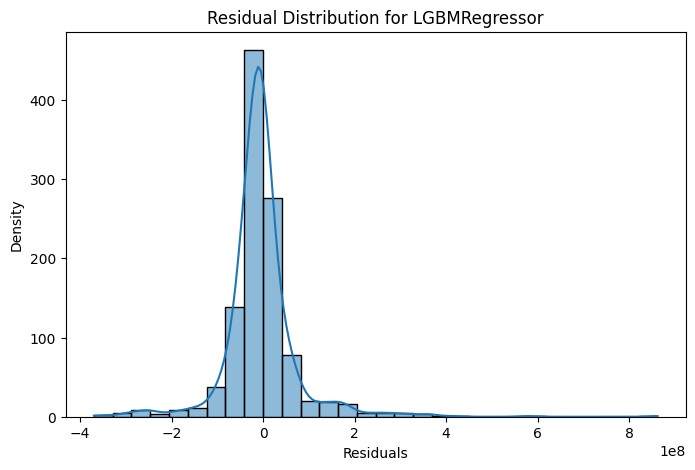

In [ ]:
_ = evaluate_model(best_lgbm, X_test_scaled, y_test)


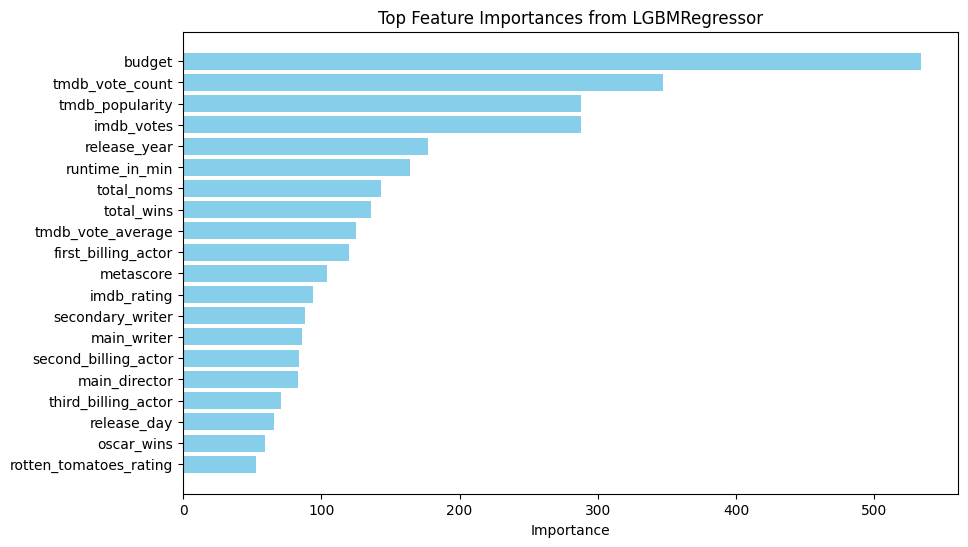

In [ ]:
display_feature_importances(best_lgbm, X_train_scaled)